In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from tqdm import tqdm
import json
import os
import random
import math
import pickle
#import umap
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix
from collections import deque

# import stellargraph as sg
# from stellargraph.mapper import FullBatchNodeGenerator
# from stellargraph.layer import GCN
import networkx as nx
import warnings
import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense, Embedding,LeakyReLU, Maximum
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
import seaborn as sns
# from stellargraph import StellarGraph
# from stellargraph.layer.gcn import GatherIndices
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

%matplotlib inline

In [ ]:
dataFrame = pd.read_csv("/content/drive/MyDrive/GCN Classification/citation_sentiment_corpus.txt", sep = "	", header = None)
dataFrame.columns = ["Source_PaperID", "Target_PaperID", "Sentiment", "Citation_text"]
dataFrame.Sentiment = dataFrame.Sentiment.replace({"o": 1,"p": 2,"n": 0})

In [ ]:
Source = dataFrame['Source_PaperID']
Target = dataFrame['Target_PaperID']
Sentiment = dataFrame['Sentiment']
G = nx.DiGraph(directed=True)
edges = pd.DataFrame(
    {
        "source": Source,
        "target": Target,
        "weight": Sentiment
    }
)
G = nx.from_pandas_edgelist(edges, edge_attr=True,create_using=nx.DiGraph())

In [ ]:
leaderboard = {}
for x in G.nodes:
 leaderboard[x] = len(G[x])
s = pd.Series(leaderboard, name='Citations')
citation_counts = s.to_frame().sort_values('Citations', ascending=False)
citation_counts.value_counts()

Citations
1            1785
2             703
3             295
4             121
0              77
5              59
6              19
7               7
8               3
dtype: int64

In [ ]:
citation_counts = citation_counts.reset_index(level=0)
citation_counts.columns = ['Node', 'Citations']
citation_counts.head()

,Node,Citations
0,W08-0306,8
1,N09-1058,8
2,D07-1070,8
3,N09-1049,7
4,P08-1068,7


In [ ]:
zero_list = []
for i,j in zip(citation_counts['Node'], citation_counts['Citations']):
    if(j == 0):
      
        zero_list.append(i)
G.remove_nodes_from(zero_list)

In [ ]:
print("Number of Nodes: ",G.number_of_nodes())
print("Number of Edges: ",G.number_of_edges())

Number of Nodes:  2992
Number of Edges:  1589


In [ ]:
import os
all_data = []

for root,dirs,files in os.walk('.'):
    for file in files:
        if 'node2vec_embeddings.txt' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
all_data

#parse the data
nodes = []
node2vec_cc = []

for i,data in enumerate(all_data):
    elements = data.split(' ')
    node2vec_cc.append(elements[1:])
    nodes.append(elements[0])

In [ ]:
node2vec_cc.pop(0)
nodes.pop(0)

'2992'

In [ ]:
len(nodes)

2992

In [ ]:
len(node2vec_cc)

2992

In [ ]:
dataset = pd.DataFrame({'Node_id': nodes, 'embeddings': node2vec_cc}, columns=['Node_id', 'embeddings'])

In [ ]:
dataset

,Node_id,embeddings
0,J97-3002,"[0.29475126, 0.29237565, 0.7402589, 0.5839545,..."
1,N03-1017,"[-0.08274625, 0.59652436, 1.2793896, -0.135234..."
2,W96-0213,"[0.08824804, -0.45551515, 0.14226653, -0.80273..."
3,W02-1011,"[-0.8990309, -0.8870302, 0.717432, 0.24402909,..."
4,P04-1035,"[-0.8811224, -1.5552723, 0.053557992, -0.05447..."
...,...,...
2987,W05-0307,"[-0.0010220176, 0.0018005054, 0.0034822198, 0...."
2988,D08-1084,"[0.0051305247, -0.00020716991, 0.0056356033, -..."
2989,I08-1016,"[-0.0021094028, -0.0057895826, -0.0016520573, ..."
2990,P09-1098,"[-0.0029256037, -0.0078072418, -0.0019403696, ..."


In [ ]:
df = dataFrame
labels = []
for i in nodes:
    for j,k in zip(df['Source_PaperID'],df['Sentiment']):
        if(i==j):
            labels.append(k)
            break

In [ ]:
dataset["label"] = labels
dataset.label.value_counts()

1    2622
2     283
0      87
Name: label, dtype: int64

In [ ]:
dataset.head()

,Node_id,embeddings,label
0,J97-3002,"[0.29475126, 0.29237565, 0.7402589, 0.5839545,...",1
1,N03-1017,"[-0.08274625, 0.59652436, 1.2793896, -0.135234...",1
2,W96-0213,"[0.08824804, -0.45551515, 0.14226653, -0.80273...",1
3,W02-1011,"[-0.8990309, -0.8870302, 0.717432, 0.24402909,...",1
4,P04-1035,"[-0.8811224, -1.5552723, 0.053557992, -0.05447...",1


In [ ]:
# N = dataset['embeddings'].shape[0] #the number of nodes
# F = dataset['embeddings'].shape[1] #the size of node features
# print('X shape: ', node2vec_cc.shape)


# print('\nNumber of nodes (N): ', N)
# print('\nNumber of features (F) of each node: ', F)
# print('\nCategories: ', set(labels))

# num_classes = len(set(labels))
# print('\nNumber of classes: ', num_classes)
# A = nx.adjacency_matrix(G)
# print('Graph info: ', nx.info(G))

In [ ]:
column_names =[f"term_{idx}" for idx in range(128)]

In [ ]:
node2vec_cc = pd.DataFrame(node2vec_cc, columns = column_names)

In [ ]:
node2vec_cc.head()

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_118,term_119,term_120,term_121,term_122,term_123,term_124,term_125,term_126,term_127
0,0.29475126,0.29237565,0.7402589,0.5839545,-0.5660996,-0.9100486,0.20029289,1.2977738,-0.116086334,0.26056316,...,-0.15942834,0.1429829,-0.07687346,-0.9226167,0.78992116,-0.84812886,0.49845138,0.38957667,-0.3366734,0.14115053
1,-0.08274625,0.59652436,1.2793896,-0.13523456,-0.29737115,-0.78901345,0.06501235,0.9344545,0.027245471,0.54895765,...,0.28383532,0.27552357,-0.088856906,-0.49268368,1.0905964,-0.65956247,-0.5185808,-0.29776338,-0.80166334,-0.30129644
2,0.08824804,-0.45551515,0.14226653,-0.80273306,1.0324552,-0.7385533,0.9176383,0.7226203,-0.89616984,1.2452774,...,0.24278162,-0.4781477,-0.6869531,0.84110194,0.27185586,0.67025656,-0.4129803,0.6605675,0.44515988,0.49230257
3,-0.8990309,-0.8870302,0.717432,0.24402909,-0.41392344,-0.68330127,-0.43823487,0.1426507,-0.9135517,-0.075670876,...,0.18539672,-0.3669928,-0.82656157,-0.0026124702,0.40108162,0.9708959,-0.65667415,-1.4535186,-0.87660235,-0.3967433
4,-0.8811224,-1.5552723,0.053557992,-0.05447238,-0.7145693,-0.44096208,-0.20929481,0.22100833,-1.2522765,-0.4542726,...,0.3774099,0.77015525,-0.3201643,0.39295188,-0.2822794,0.3054697,-0.4024803,-0.9890051,-1.0255593,-0.8270502


In [ ]:
node2vec_cc["Node_id"] = dataset["Node_id"]
node2vec_cc["label"] = dataset["label"]

In [ ]:
graph = nx.to_pandas_edgelist(G)
graph

,source,target,weight
0,W09-0604,N03-1003,1
1,A00-1031,W96-0213,1
2,A97-1004,W96-0213,1
3,C08-1026,P08-1085,2
4,N01-1023,W96-0213,1
...,...,...,...
1584,W07-1209,W96-0213,1
1585,W07-1516,W96-0213,2
1586,W07-2053,W96-0213,1
1587,W08-0611,W96-0213,1


In [ ]:
paper_idx = {name: idx for idx, name in enumerate(node2vec_cc["Node_id"])}

node2vec_cc["Node_id"] = node2vec_cc["Node_id"].apply(lambda name: paper_idx[name])
graph["source"] = graph["source"].apply(lambda name: paper_idx[name])
graph["target"] = graph["target"].apply(lambda name: paper_idx[name])

In [ ]:
train_label_cc, test_pages = train_test_split(node2vec_cc['label'], test_size = 0.30)
val_label_cc, test_label_cc = train_test_split(test_pages, test_size=0.40)

In [ ]:
train_Node2Vec_cc = node2vec_cc.loc[train_label_cc.index]
val_Node2Vec_cc = node2vec_cc.loc[val_label_cc.index]
test_Node2Vec_cc = node2vec_cc.loc[test_label_cc.index]

In [ ]:
train_Node2Vec_cc.head()

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_120,term_121,term_122,term_123,term_124,term_125,term_126,term_127,Node_id,label
996,0.35939226,-0.70101476,0.38239765,0.12158254,0.13269731,-0.7182991,0.55925804,-0.06400827,-0.27492687,-0.49874616,...,-0.54493636,-0.026914435,-0.21945074,-0.009273394,0.0011678695,-0.092896566,-0.782745,-0.16456325,996,1
84,-0.096334904,-0.32829517,0.62843037,-0.102034226,0.19675007,-0.21955732,0.2588937,-0.128193,-0.39881945,0.16058382,...,-0.35210565,0.20737095,0.33592412,0.15392606,-0.15664332,-0.2877624,-0.20933847,-0.19281831,84,1
319,0.0006281175,0.0016151881,0.0068212654,-0.00022625085,-0.006196644,0.004511852,-0.004581255,0.00022332929,-0.0077435765,0.0064395396,...,0.006753723,0.00025309995,0.0032963622,-0.005421657,-0.0007027257,0.0063171703,-0.0022179699,0.004160939,319,1
153,-0.0051632486,0.007131177,-0.0053944914,0.0044780243,0.006634076,-0.0030901534,0.0066105416,0.0071015805,0.0031554904,0.0074693747,...,0.00012120791,-0.007149201,-0.0076576686,-0.004614393,-0.007168701,0.0023534698,-0.002649759,0.0034442889,153,1
658,-0.0029472169,-0.00088754296,-0.00465813,-0.002817736,-0.0063491194,0.0076457877,-0.006566883,-0.005414848,-0.004105909,-0.0026152106,...,0.0059685754,0.00017951708,0.0045928303,-0.0015728688,-0.005102547,-0.0061730025,0.00062939804,-0.004144213,658,1


In [ ]:
train_Node2Vec_cc.shape, val_Node2Vec_cc.shape, test_Node2Vec_cc.shape

((2094, 130), (538, 130), (360, 130))

In [ ]:
test_Node2Vec_cc

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_120,term_121,term_122,term_123,term_124,term_125,term_126,term_127,Node_id,label
2883,0.005878794,-0.005243172,0.0011150884,-0.00048538763,-0.006632657,0.0054580094,-0.0045597013,-0.0013827458,0.0012130942,0.0011097258,...,0.0047726,-0.0040184306,-0.0010400303,0.0076395506,0.001980001,-0.006822952,0.0012518456,-0.0040547783,2883,1
2728,-0.0012522535,0.0027243448,-0.005974937,0.0039437637,0.004423418,0.0052935435,0.0028644614,-0.0035386365,0.0018672366,-0.0049501536,...,0.005604417,-0.005999551,0.006521806,0.00028386805,-0.0034634573,-0.0003145961,0.006613274,-0.0073471535,2728,1
2483,-0.0066172658,-0.0069957227,0.0044481494,0.0051723393,0.0057823025,-0.0029000724,0.003691244,0.0006403979,-0.002180582,0.0042756097,...,-0.0022081174,-0.005835356,-0.0036743218,0.0068559414,-0.0063344305,0.0052752644,-2.4894252e-05,0.0060442034,2483,1
2706,0.015214162,-0.28106675,0.33736083,0.047544073,0.22599877,-0.22882077,0.04232037,-0.08474961,-0.1531509,-0.13315569,...,-0.129045,0.062390067,0.08513391,0.09749582,0.049423873,-0.14867055,-0.30249476,-0.0024577675,2706,1
827,-0.12684678,-0.47232908,-0.024341887,0.38971883,0.21235277,-0.3049125,0.10923049,0.13695297,0.19658644,-0.17734808,...,-0.40042698,-0.06684447,-0.32447717,0.09185344,-0.103567824,0.059776545,-0.47923252,-0.41603625,827,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,0.34530324,-0.569344,0.5496167,0.018804528,0.13560116,-0.22724456,0.2335509,0.38375148,-0.020646436,-0.3796282,...,-0.0818402,-0.19164184,0.20738128,0.2358133,-0.0366619,-0.18051869,0.032858286,0.10710801,1423,1
1603,0.11557469,-0.3231648,0.3056504,0.00915206,-0.14974004,-0.4377437,0.1944513,0.30118808,-0.029794583,-0.06455693,...,-0.14530827,-0.16950801,-0.10284055,-0.065579385,0.1344307,0.0034790682,-0.30204478,0.24739927,1603,1
2542,0.0075920764,0.0005499404,-0.005782428,-0.00036231335,0.0076330807,0.004934647,0.0045117512,0.005239672,0.002159954,-7.65929e-05,...,0.0042718137,-0.006637535,0.007241294,0.0035786303,-0.0032372037,-0.0069415756,0.0037801983,2.6171096e-05,2542,1
918,0.006093421,-0.005094275,0.007125007,0.006384461,-0.005961911,0.0029478949,0.00087760296,0.007202155,-0.0058927583,0.00057355873,...,-0.0015715146,-0.0012265546,0.005311761,0.0033558356,0.0029514749,0.005064653,-0.00047799107,0.0068178857,918,1


In [ ]:
y_train = np.array(list(train_label_cc.values))
y_val = np.array(list(val_label_cc.values))
y_test = np.array(list(test_label_cc.values))

In [ ]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
graph.head()

,source,target,weight
0,2043,6,1
1,665,2,1
2,2769,2,1
3,2390,58,2
4,2659,2,1


In [ ]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = graph[["source", "target"]].to_numpy().T

# Create an edge weights array of ones.
# edge_weights =tf.cast(graph_cc['combined_score'].to_numpy(),dtype = tf.dtypes.float32) 

edge_weights = tf.ones(shape=edges.shape[1],dtype = tf.dtypes.float32)
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    node2vec_cc.sort_values('Node_id')[column_names].apply(pd.to_numeric).to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 1589)
Nodes shape: (2992, 128)


In [1]:
edges

NameError: ignored

In [ ]:
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [32, 32]
dropout = 0.5
kernel_regularizer='l2'

hidden_units = [256,128]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 100
batch_size = 256
bias_regularizer = "l2"

In [ ]:
import numpy as np
import datetime

def accuracy(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true), ', set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def precision(y_true, y_pred, normalize=True, sample_weight=None):
    pre_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_prec = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_prec = 1
            pre_list.append(tmp_prec)
        elif len(set_pred) > 0:
            tmp_prec = len(set_true.intersection(set_pred))/\
                    float(len(set_pred))
            pre_list.append(tmp_prec)
        else:
            None
    return np.mean(pre_list)

# def recall(y_true, y_pred, normalize=True, sample_weight=None):
#     rec_list = []
#     for i in range(y_true.shape[0]):
#         set_true = set( np.where(y_true[i])[0] )
#         set_pred = set( np.where(y_pred[i])[0] )
#         tmp_rec = None
#         if len(set_true) == 0 and len(set_pred) == 0:
#             tmp_rec = 1
#         else:
#             tmp_rec = len(set_true.intersection(set_pred))/\
#                     float(len(set_true))
#         rec_list.append(tmp_rec)
#     return np.mean(rec_list)

def recall(y_true, y_pred, normalize=True, sample_weight=None):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=1)
    
    rec_list = []
    
    for i in range(possible_positives.shape[0]):
        set_true = set(np.where(y_true[i])[0])
        set_pred = set(np.where(y_pred[i] >= 0.5)[0])
        
        if len(set_true) == 0:
            tmp_rec = 0
        else:
            tmp_rec = len(set_true.intersection(set_pred))/float(len(set_true))
        
        rec_list.append(tmp_rec)
    
    if normalize:
        return np.mean(rec_list)
    else:
        return np.sum(true_positives) / (np.sum(possible_positives) + K.epsilon())


def f_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = (2*len(set_true.intersection(set_pred)))/\
                    float( len(set_true) + len(set_pred))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
def run_experiment(model, x_train, y_train, x_val, y_val):
    # Compile the model.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data = (x_val, y_val),
        callbacks=[early_stopping],
    )

    return history

In [ ]:
class BatchNormalization(keras.layers.Layer):

  def build(self, input_shape):
    # print("Batch Input Shape:", input_shape)
    dim = input_shape[-1]
    self.gamma = self.add_weight(shape=(dim,),
                                 initializer=keras.initializers.ones,
                                 trainable=True)
    self.beta = self.add_weight(shape=(dim,),
                                initializer=keras.initializers.zeros,
                                trainable=True)
    self.var = self.add_weight(shape=(dim,),
                               initializer=keras.initializers.ones,
                               trainable=False)
    self.mean = self.add_weight(shape=(dim,),
                                initializer=keras.initializers.zeros,
                                trainable=False)

  def call(self, inputs, training=None):
    if training:
      mean, var = tf.nn.moments(inputs,
                                axes=[i for i in range(inputs.shape.rank - 1)])
      normalized = (inputs - mean) / var
      self.var.assign(self.var * 0.9 + var * 0.1)
      self.mean.assign(self.mean * 0.9 + mean * 0.1)
    else:
      normalized = (inputs - self.mean) / self.var
    return normalized * self.gamma + self.beta


In [ ]:
import tensorflow as tf

# from .layers import Layer, Dense
# from .inits import glorot, zeros

class MeanAggregator(keras.layers.Layer):
    """
    Aggregates via mean followed by matmul and non-linearity.
    """

    def __init__(self,units,
            dropout=0., bias=False, act=tf.nn.relu, 
            name=None, concat=False,**kwargs):
        super(MeanAggregator, self).__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat
        
    def get_config(self):
        config = super(MeanAggregator, self).get_config()
        config.update({"units": self.units, "dropout":self.dropout, "bias":self.bias, "activation":self.act, "concat":self.concat})
        return config

    def build(self, input_shape): 
        # print("Input shape:", input_shape[0][-1])
        input_dim = input_shape[0][-1]
        w_init = tf.random_normal_initializer()
        self.neigh_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'), trainable=True)
        self.self_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
          b_init = tf.zeros_initializer()
          self.bias_init = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)
        super(MeanAggregator, self).build(input_shape = input_shape)

     
    def call(self, inputs, training = None):
        self_vecs, neigh_vecs = inputs

        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs
        # neigh_vecs = tf.nn.dropout(neigh_vecs, 1-self.dropout)
        # self_vecs = tf.nn.dropout(self_vecs, 1-self.dropout)
        neigh_means = tf.math.unsorted_segment_mean(neighbour_messages, node_indices, num_segments=num_nodes)
        # print("Neighbour means:",neigh_means.shape)
        # [nodes] x [out_dim]
        from_neighs = tf.matmul(neigh_means, self.neigh_weights)
        
        from_self = tf.matmul(self_vecs, self.self_weights)
         
        if not self.concat:
            output = tf.add_n([from_self, from_neighs])
        else:
            output = tf.concat([from_self, from_neighs], axis=1)

        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)
    
class GCNAggregator(Layer):
    """
    Aggregates via mean followed by matmul and non-linearity.
    Same matmul parameters are used self vector and neighbor vectors.
    """

    def __init__(self, units,
            dropout=0., bias=False, act=tf.nn.relu, name=None, concat=False, **kwargs):
        super(GCNAggregator, self).__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat
        
    def build(self, input_shape):  
        input_dim = input_shape[0][-1]
        initializer = tf.keras.initializers.GlorotNormal()
        self.W = tf.Variable(initial_value=initializer(shape = (2*input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
            zeros = tf.keras.initializers.zeros()
            self.bias_init= tf.Variable(initial_value=zeros(shape =(self.units),dtype='float32'),trainable=True)

        super(GCNAggregator, self).build(input_shape = input_shape)
        
    def call(self, inputs):
        self_vecs, neigh_vecs = inputs

        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs
        neigh_means = tf.math.unsorted_segment_mean(neighbour_messages, node_indices, num_segments=num_nodes)

        # neigh_means = tf.nn.dropout(neigh_vecs, 1-self.dropout)
        # self_vecs = tf.nn.dropout(self_vecs, 1-self.dropout)

        means = tf.concat([neigh_means,self_vecs], axis=1)
        
        # [nodes] x [out_dim]
        output = tf.matmul(means, self.W)

        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)


class MaxPoolingAggregator(Layer):
    """ Aggregates via max-pooling over MLP functions.
    """
    def __init__(self, units,
            dropout=0., bias=False, act=tf.nn.relu, name=None, concat=False, **kwargs):
        super(MaxPoolingAggregator, self).__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat
  
        hidden_dim = self.hidden_dim = 512
        self.mlp_layers = []
        self.mlp_layers.append(Dense(units=hidden_dim,
                                 activation=tf.nn.relu))

    def build(self, input_shape): 
        # print("Input shape:", input_shape[0][-1])
        input_dim = input_shape[0][-1]
        w_init = tf.random_normal_initializer()
        self.neigh_weights = tf.Variable(initial_value=w_init(shape=(self.hidden_dim, self.units),dtype='float32'), trainable=True)
        self.self_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
          b_init = tf.zeros_initializer()
          self.bias_init = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)
        super(MaxPoolingAggregator, self).build(input_shape = input_shape)

    def call(self, inputs, training = None):
        self_vecs, neigh_vecs = inputs
        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs

        # [num_edges] x [hidden_dim]
        h_reshaped = neighbour_messages

        for l in self.mlp_layers:
            h_reshaped = l(h_reshaped)

        neighbour_messages = h_reshaped

        neigh_h = tf.math.unsorted_segment_max(neighbour_messages, node_indices, num_segments=num_nodes)
        
        from_neighs = tf.matmul(neigh_h, self.neigh_weights)
        from_self = tf.matmul(self_vecs, self.self_weights)
        
        if not self.concat:
            output = tf.add_n([from_self, from_neighs])
        else:
            output = tf.concat([from_self, from_neighs], axis=1)

        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)

class MeanPoolingAggregator(Layer):
    """ Aggregates via mean-pooling over MLP functions.
    """
    def __init__(self, units,
            dropout=0., bias=False, act=tf.nn.relu, name=None, concat=False, **kwargs):
        super(MeanPoolingAggregator, self).__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat 
      
        hidden_dim = self.hidden_dim = 512

        self.mlp_layers = []
        self.mlp_layers.append(Dense(units=hidden_dim,
                                 activation=tf.nn.relu))

     
    def build(self, input_shape): 
        # print("Input shape:", input_shape[0][-1])
        input_dim = input_shape[0][-1]
        w_init = tf.random_normal_initializer()
        self.neigh_weights = tf.Variable(initial_value=w_init(shape=(self.hidden_dim, self.units),dtype='float32'), trainable=True)
        self.self_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
          b_init = tf.zeros_initializer()
          self.bias_init = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)
        super(MeanPoolingAggregator, self).build(input_shape = input_shape)

    def call(self, inputs):
        self_vecs, neigh_vecs = inputs
        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs

        # [num_edges] x [hidden_dim]
        h_reshaped = neighbour_messages

        for l in self.mlp_layers:
            h_reshaped = l(h_reshaped)

        neighbour_messages = h_reshaped

        neigh_h = tf.math.unsorted_segment_mean(neighbour_messages, node_indices, num_segments=num_nodes)
        
        from_neighs = tf.matmul(neigh_h, self.neigh_weights)
        from_self = tf.matmul(self_vecs, self.self_weights)
        
        if not self.concat:
            output = tf.add_n([from_self, from_neighs])
        else:
            output = tf.concat([from_self, from_neighs], axis=1)

        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)


class TwoMaxLayerPoolingAggregator(Layer):
    """ Aggregates via pooling over two MLP functions.
    """
    def __init__(self, input_dim, output_dim, model_size="small", neigh_input_dim=None,
            dropout=0., bias=False, act=tf.nn.relu, name=None, concat=False, **kwargs):
        super(TwoMaxLayerPoolingAggregator, self).__init__(**kwargs)

        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat


        
        hidden_dim_1 = self.hidden_dim_1 = 512
        hidden_dim_2 = self.hidden_dim_2 = 256

        self.mlp_layers = []
        self.mlp_layers.append(Dense(units=hidden_dim_1,
                                 activation=tf.nn.relu))
        self.mlp_layers.append(Dense(units =hidden_dim_2,
                                 activation=tf.nn.relu))

    def build(self, input_shape): 
        # print("Input shape:", input_shape[0][-1])
        input_dim = input_shape[0][-1]
        w_init = tf.random_normal_initializer()
        self.neigh_weights = tf.Variable(initial_value=w_init(shape=(self.hidden_dim_2, self.units),dtype='float32'), trainable=True)
        self.self_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
          b_init = tf.zeros_initializer()
          self.bias_init = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)
        super(TwoMaxLayerPoolingAggregator, self).build(input_shape = input_shape)

    def call(self, inputs, training = None):
        self_vecs, neigh_vecs = inputs
        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs

        # [num_edges] x [hidden_dim]
        h_reshaped = neighbour_messages

        for l in self.mlp_layers:
            h_reshaped = l(h_reshaped)

        neighbour_messages = h_reshaped

        neigh_h = tf.math.unsorted_segment_max(neighbour_messages, node_indices, num_segments=num_nodes)
        
        from_neighs = tf.matmul(neigh_h, self.neigh_weights)
        from_self = tf.matmul(self_vecs, self.self_weights)
        
        if not self.concat:
            output = tf.add_n([from_self, from_neighs])
        else:
            output = tf.concat([from_self, from_neighs], axis=1)

        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)

class SeqAggregator(Layer):
    """ Aggregates via a standard LSTM.
    """
    def __init__(self, units,
            dropout=0., bias=False, act=tf.nn.relu, name=None,  concat=False, **kwargs):
        super(SeqAggregator, self).__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat

        # hidden_dim = self.hidden_dim = 128

    
        # self.lstm = tf.keras.layers.LSTM(units = hidden_dim)
        self.gru = layers.GRU(
                units=self.units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                # return_state=True,
                # recurrent_dropout=dropout_rate,
            )
        

    def build(self, input_shape): 
        # print("Input shape:", input_shape[0][-1])
        input_dim = input_shape[0][-1]
        w_init = tf.random_normal_initializer()
        self.neigh_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'), trainable=True)
        self.self_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
          b_init = tf.zeros_initializer()
          self.bias_init = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)
        super(SeqAggregator, self).build(input_shape = input_shape)

    def call(self, inputs):
        self_vecs, neigh_vecs = inputs
        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs
        
        neigh_h = tf.math.unsorted_segment_max(neighbour_messages, node_indices, num_segments=num_nodes)
        # Create a sequence of two elements for the GRU layer.
        #print(neigh_h)
        from_neighs = tf.matmul(neigh_h, self.neigh_weights)
        from_self = tf.matmul(self_vecs, self.self_weights)
        
        h = tf.stack([from_self, from_neighs], axis=1)

        output = self.gru(h)
      
        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)

In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        units,
        dropout_rate=0.2,
        aggregation_type="mean",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)
        self.units = units
        self.aggregation_type = aggregation_type
        # self.combination_type = combination_type
        self.normalize = normalize

        if self.aggregation_type == "mean":
          self.aggregator_cls = MeanAggregator
        elif self.aggregation_type == "gated":
          self.aggregator_cls = SeqAggregator
        elif self.aggregation_type == "maxpool":
          self.aggregator_cls = MaxPoolingAggregator
        elif self.aggregation_type == "twomaxpool":
          self.aggregator_cls = TwoMaxLayerPoolingAggregator
        elif self.aggregation_type == "meanpool":
          self.aggregator_cls = MeanPoolingAggregator
        elif self.aggregation_type == "gcn":
          self.aggregator_cls = GCNAggregator
        else:
          raise Exception("Unknown aggregator: ", self.aggregator_cls)

        self.aggregator = self.aggregator_cls(self.units, act=lambda x :x,  #tf.keras.activations.sigmoid(x)
                            dropout=dropout_rate, bias = True)
                            # name=name, concat=concat)   

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_representations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_representations = tf.gather(node_representations, neighbour_indices)

        node_embeddings = self.aggregator((node_representations, (node_indices, neighbour_representations)))
    
        aggregated_messages = node_embeddings
        if self.normalize:
            aggregated_messages = tf.nn.l2_normalize(aggregated_messages, axis=-1)  

        return aggregated_messages


In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        #self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units[0],
            dropout_rate,
            aggregation_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.batch_norm1 = BatchNormalization()
        self.conv2 = GraphConvLayer(
            hidden_units[1],
            dropout_rate,
            aggregation_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.batch_norm2 = BatchNormalization()
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, activation = 'sigmoid',name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        #x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((self.node_features, self.edges, self.edge_weights))
        # Skip connection.
        x1 = self.batch_norm1(x1)
        # x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x1, self.edges, self.edge_weights))
        x2 = self.batch_norm2(x2)
        # Skip connection.
        # x = x2 + x
        # Postprocess node embedding.
        # x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        input_node_indices = tf.cast(input_node_indices, dtype=tf.int32)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x2, input_node_indices)

        #node_embeddings = tf.gather(x2, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [ ]:
class BidLSTM(keras.layers.Layer):
    """ Bidirectional LSTM Layer.
        Reference:
            - [LSTM](https://arxiv.org/abs/1402.1128)
    """
    def __init__(self, units=100):
        """
        Initialize the BidLSTM layer.
        :param units: num of hidden units.
        """
        super(BidLSTM, self).__init__()
        forward_layer = keras.layers.LSTM(
            units=units,
            return_sequences=True,
            return_state=True)
        backward_layer = keras.layers.LSTM(
            units=units,
            return_sequences=True,
            return_state=True,
            go_backwards=True)
        self.bidirectional_rnn = keras.layers.Bidirectional(
            layer=forward_layer,
            backward_layer=backward_layer)

    def build(self, input_shape):
        super(BidLSTM, self).build(input_shape=input_shape)

    def call(self, inputs, mask = None, **kwargs):
        """
        Call function of BidLSTM layer.
        :param inputs: shape = (batch_size, time_steps, channel)
        :param mask: shape = (batch_size, time_steps)
        :param kwargs: None.
        :return: (sequence_output, state_output).
                  sequence_output shape is (batch_size, time_steps, units x 2),
                  state_output shape is (batch_size, units x 2)
        """
        output = self.bidirectional_rnn(inputs, mask=mask)
        sequence_output = output[0]
        forward_state_output = output[1]
        backward_state_output = output[2]
        state_output = tf.keras.layers.concatenate([forward_state_output, backward_state_output], axis=-1)
        return sequence_output, state_output

    @staticmethod
    def create_padding_mask(seq_len, max_len):
        """
        Create the padding mask matrix according to the seq_len and max_len.
        Set the value to 0 to mask the padding sequence.
        :param seq_len: the sequence length.
        :param max_len: the max length.
        :return: padding mask matrix. (shape = (batch_size, max_len))
        """
        mask_matrix = tf.sequence_mask(seq_len, maxlen=max_len)
        return mask_matrix


class MultiHeadAttention(keras.layers.Layer):
    """ MultiHeadAttention Layer.
        Multi-head attention by q, k, v.
        Schematic:
            1\ Linear layer and split to multi heads.
            2\ Scaled dot-product attention.
            3\ Concatenate the heads.
            4\ Final linear layer.
        Reference:
            - [Multi-Head Attention](https://arxiv.org/abs/1706.03762)(Attention is all you need.)
            - https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/transformer.ipynb
    """
    def __init__(self, num_dimensions, num_heads):
        """
        Initialize the MultiHeadAttention layer.
        :param num_dimensions: the number of the dimensions of the layer.
        :param num_heads: the number of the heads of the layer.
        """
        super(MultiHeadAttention, self).__init__()
        # The num_dimensions must be divisible by num_heads.
        assert num_dimensions % num_heads == 0

        self.num_dimensions = num_dimensions
        self.num_heads = num_heads
        self.depth = self.num_dimensions // self.num_heads

        self.wq = keras.layers.Dense(num_dimensions)
        self.wk = keras.layers.Dense(num_dimensions)
        self.wv = keras.layers.Dense(num_dimensions)

        self.dense = keras.layers.Dense(num_dimensions)
    
    def build(self, input_shape):
        super(MultiHeadAttention, self).build(input_shape=input_shape)

    def call(self, q, k=None, v=None, mask=None):
        """
        Call function of MultiHeadAttention.
        :param q: the query. shape = (batch_size, seq_len_q, None)
        :param k: the key. shape = (batch_size, seq_len_k, None)
        :param v: the value. shape = (batch_size, seq_len_v, None)
        :param mask: Padding_mask.shape = (batch_size, 1, 1, seq_len)/Lookahead_mask.shape = (seq_len, seq_len)
        :return: outputs and attention weights.
        """
        # 1\ Linear layer and split to multi heads.
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len_q, num_dimensions)
        k = self.wk(k)  # (batch_size, seq_len_k, num_dimensions)
        v = self.wv(v)  # (batch_size, seq_len_v, num_dimensions)
        q = self.split_heads(q, batch_size, self.num_heads, self.depth)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size, self.num_heads, self.depth)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size, self.num_heads, self.depth)  # (batch_size, num_heads, seq_len_v, depth)

        # 2\ Scaled dot-product attention.
        # attention_outputs.shape = (batch_size, num_heads, seq_len_q, depth_v)
        # attention_weights.shape = (batch_size, num_heads, seq_len_q, seq_len_k)
        attention_outputs, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        # 3\ Concatenate the heads.
        # temp.shape = (batch_size, seq_len_q, num_heads, depth)
        # concat_attention.shape = (batch_size, seq_len_q, num_dimensions)
        temp = tf.transpose(attention_outputs, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(temp, (batch_size, temp.shape[1], self.num_dimensions))

        # 4\ Final linear layer.
        # output.shape = (batch_size, seq_len_q, num_dimensions)
        outputs = self.dense(concat_attention)

        return outputs, attention_weights

    @staticmethod
    def split_heads(x, batch_size, num_heads, depth):
        """
        Split the last dimension into (num_heads, depth).
        Then Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        :param x: shape = (batch_size, seq_len, num_dimensions)
        :param num_heads: batch size
        :param depth: depth
        :return: shape = (batch_size, num_heads, seq_len, depth)
        """
        temp = tf.reshape(x, (batch_size, x.shape[1], num_heads, depth))
        temp = tf.transpose(temp, perm=[0, 2, 1, 3])
        return temp

    @staticmethod
    def scaled_dot_product_attention(q, k, v, mask):
        """
        Calculate the attention weights.
        Schematic:
            1\ Calculate the matmul_qk.
            2\ Scale matmul_qk.
            3\ Add the mask to the scaled tensor.
            4\ Softmax and Weighted Summation.
        Note:
            1\ q, k, v must have matching leading dimensions.
            2\ q, k must have matching last dimensions. (depth_q = depth_v)
            3\ k, v must have matching penultimate dimensions. (seq_len_k = seq_len_v)
            4\ The mask has different shapes depending on its type (padding or look ahead),
               but it must be broadcastable for addition.
        :param q: query, shape = (batch_size, num_heads, seq_len_q, depth_q)
        :param k: key, shape = (batch_size, num_heads, seq_len_k, depth_k)
        :param v: value, shape = (batch_size, num_heads, seq_len_v, depth_v)
        :param mask: Float tensor with shape broadcastable to (batch_size, num_heads, seq_len_q, seq_len_k).
        :return: output, attention_weights
        """
        # 1\ Calculate the matmul_qk.
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, num_heads, seq_len_q, seq_len_k)

        # 2\ Scale matmul_qk.
        d = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d)

        # 3\ Add the mask to the scaled tensor.
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # 4\ Softmax and Weighted Summation.
        # attention_weights.shape = (batch_size, num_heads, seq_len_q, seq_len_k)
        # attetion_outputs.shape = (batch_size, num_heads, seq_len_q, depth_v)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention_outputs = tf.matmul(attention_weights, v)
        return attention_outputs, attention_weights

    @staticmethod
    def create_padding_mask(seq):
        """
        Create padding mask.
        Set 1 to mask the padding.
        :param seq: sequence. shape = (batch_size, seq_len)
        :return: mask matrix. shape = (batch_size, seq_len)
        """
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        # add extra dimensions to add the padding to the attention logits.
        mask = mask[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)
        return mask

    @staticmethod
    def create_look_ahead_mask(size):
        """
        Create look-ahead mask.
        Set 1 to mask the future information.
        :param size: size.
        :return: mask matrix. shape = (size, size)
        """
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (size, size)


In [ ]:
aggregation = ["gcn","mean","gated","meanpool","maxpool","twomaxpool"]
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=3,
    aggregation_type="gcn",
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [ ]:
print("GNN output shape:", gnn_model([5, 10, 100]))

# gnn_model.summary()

GNN output shape: tf.Tensor(
[[0.54449224 0.51276344 0.4904159 ]
 [0.5243334  0.4685546  0.52249104]
 [0.44690502 0.4985554  0.48395026]], shape=(3, 3), dtype=float32)


In [ ]:
# train_Node2Vec_cc['embeddings'] = train_Node2Vec_cc[train_Node2Vec_cc.columns[1:]].apply(
#     lambda x: ','.join(x.dropna().astype(str)),
#     axis=1
# )

In [ ]:
x_train = train_Node2Vec_cc.Node_id.to_numpy()
x_val = val_Node2Vec_cc.Node_id.to_numpy()
x_test = test_Node2Vec_cc.Node_id.to_numpy()

In [ ]:
x_val.shape, x_train.shape, x_test.shape

((538,), (2094,), (360,))

In [ ]:
from keras.utils import to_categorical
# convert to one-hot encoded format
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

# print the shape of the one-hot encoded labels
print(y_train_onehot.shape)
print(y_val_onehot.shape)

(2094, 3)
(538, 3)


In [ ]:
history = run_experiment(gnn_model, x_train, y_train_onehot, x_val, y_val_onehot)

Epoch 1/100
9/9 [==============================] - 6s 262ms/step - loss: 7.3249 - binary_accuracy: 0.4949 - val_loss: 0.5131 - val_binary_accuracy: 0.9108
Epoch 2/100
9/9 [==============================] - 2s 244ms/step - loss: 1.1155 - binary_accuracy: 0.6289 - val_loss: 0.4256 - val_binary_accuracy: 0.9027
Epoch 3/100
9/9 [==============================] - 3s 359ms/step - loss: 0.6479 - binary_accuracy: 0.7612 - val_loss: 0.3810 - val_binary_accuracy: 0.8296
Epoch 4/100
9/9 [==============================] - 4s 457ms/step - loss: 0.4814 - binary_accuracy: 0.8182 - val_loss: 0.3370 - val_binary_accuracy: 0.9089
Epoch 5/100
9/9 [==============================] - 3s 299ms/step - loss: 0.3945 - binary_accuracy: 0.8504 - val_loss: 0.3773 - val_binary_accuracy: 0.8302
Epoch 6/100
9/9 [==============================] - 1s 150ms/step - loss: 0.3573 - binary_accuracy: 0.8658 - val_loss: 0.3024 - val_binary_accuracy: 0.9108
Epoch 7/100
9/9 [==============================] - 1s 104ms/step - los

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "validation"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["binary_accuracy"])
    ax2.plot(history.history["val_binary_accuracy"])
    ax2.legend(["train", "validation"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()
    

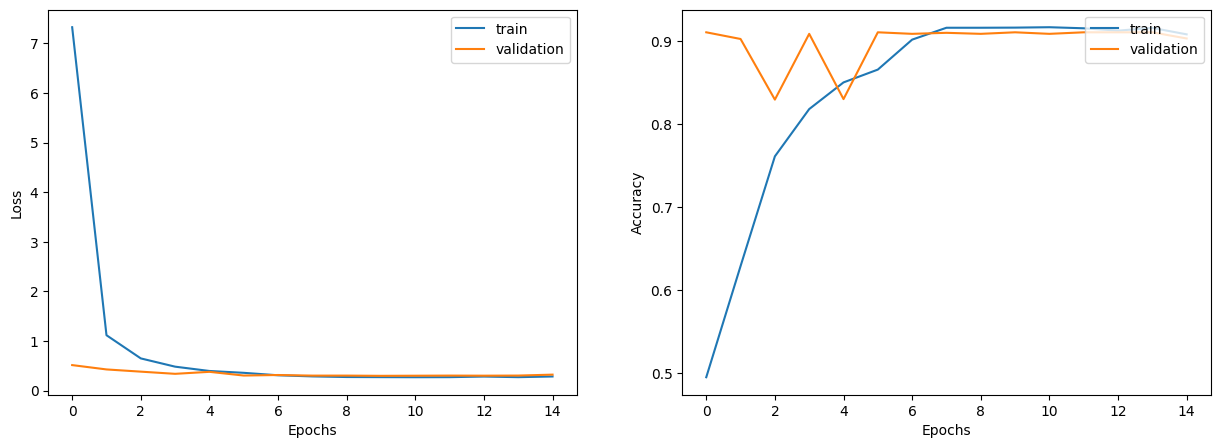

In [ ]:
display_learning_curves(history)

In [ ]:
from matplotlib import pyplot as plt
import math
# Testing
def test_fun(full_model,x_test,y_test):
    # X_test_new, Y_test_new = final_model(file)
    # print(X_test_new.shape, Y_test_new.shape)
    # Y_test_new = np.array(Y_test_new).astype(None)
    #k_labels = np.array(k_labels).astype(None)
    fmax, tmax = 0.0, 0.0
    precisions, recalls = [], []
    for t in range(1, 101, 1):
        test_preds = full_model.predict(x=x_test)
        #test_preds = full_model.predict(x = [seq_test_data])
        threshold = t / 100.0
        if(threshold == 1.0):
            threshold = 0.99
        print("THRESHOLD IS =====> ", threshold)
        # print(test_preds.shape)
        
        
        test_preds[test_preds>=threshold] = int(1)
        test_preds[test_preds<threshold] = int(0)
        # print(test_preds.shape)
        # print(k_labels.shape)
        rec = recall(y_test, test_preds)

        pre = precision(y_test, test_preds)
        
        recalls.append(rec)
        
        precisions.append(pre)
        # if(pre > 80):
        #   break
        f1 = f_score(y_test, test_preds)*100
        f = 2 * pre * rec / (pre + rec)
        if math.isnan(f):
          f = 0.0
        print('Recall: {0}'.format(rec*100), '     Precision: {0}'.format(pre*100),
              '     F1-score1: {0}'.format(f*100), '      F1-score2: {0}'.format(f1))

        if fmax < f:
            fmax = f
            tmax = threshold
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    sorted_index = np.argsort(recalls)
    recalls = recalls[sorted_index]
    precisions = precisions[sorted_index]
    aupr = np.trapz(precisions, recalls)
    print(f'AUPR: {aupr:0.3f}')

    plt.figure()
    plt.plot(recalls, precisions, color='darkorange', lw=2, label=f'AUPR curve (area = {aupr:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Area Under the Precision-Recall curve')
    plt.legend(loc="upper right")
    plt.savefig(f'aupr.pdf')

    return tmax
# print("*****************************************GCC EVALUATION******************************************")
# th_set_GCC = test_fun(gnn_model,x_test,y_test)
# print(th_set_GCC)

# th_set_only_LSTM = test_fun(LSTM_model,test_seq_cc,test_label_cc)


# print(th_set_only_LSTM)



In [ ]:
es_callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [ ]:

def LSTMmodel(features_input,functions):
  n_nodes = features_input.shape[0]
  n_features = features_input.shape[1]
  #batch_size = tf.shape(features_input)[1]
  training=None 
  mask=None
  _input = layers.Input(shape=(1000,))
  batch_size = tf.shape(_input)[0]
  #input = Input(shape=[1,n_nodes])
  #z = tf.squeeze(
   # inputs, axis=0, name=None)
  # z = tf.squeeze(z,axis = 0)
  #print(inputs.shape)
  emb = Embedding(
        input_dim = 8000,
        output_dim = 128,
        input_length= 1000
        )(_input)
    #model.add((LSTM(256,return_sequences=True)))
  # emb = tf.squeeze(
#     emb, axis=0, name=None
# )
  #print(emb.shape)
  conv_1 = keras.layers.Conv1D(
            filters=1024,
            kernel_size=128,
            strides=1,
            padding='valid',
            activation='relu')(emb)

  pool_1 = keras.layers.MaxPool1D(
            pool_size=64,
            strides=32,
            padding='valid')(conv_1)

  dropout_1 = keras.layers.Dropout(0.2)(pool_1)

  temp, state_output = BidLSTM(128)(dropout_1)
  #temp, _ = bidirectional_rnn(dropout_1)# training=training, mask=mask)
  # category_encoding = tf.eye(functions.shape[0])[tf.newaxis, :, :]
  # query = tf.tile(category_encoding, multiples=[batch_size, 1, 1])
  multi_head_attention = MultiHeadAttention(400, 8)
  temp, _ = multi_head_attention(temp, k=temp, v=temp)
  # dropout_2 = keras.layers.Dropout(0.2)(temp,training=training)
  # point_wise_dense_1 = keras.layers.Dense(
  #           units=100,
  #           activation='relu')(dropout_2)

  # point_wise_dense_2 = keras.layers.Dense(
  #           units=1,
  #           activation='sigmoid')(point_wise_dense_1)


  
  # output = tf.reshape(point_wise_dense_2, [-1, functions.shape[0]])
  # # print(output.shape)
  # # dense_1 = tf.keras.layers.Dense(512,activation = 'relu')(state_output)
  # output = tf.keras.layers.Dense(functions.shape[0],activation = 'sigmoid')(output)

  #x = layers.Lambda(lambda xin: K.sum(xin, axis=1))(x)
  # x = layers.Flatten()(temp)
  x = layers.GlobalAveragePooling1D()(temp)
  dropout_2 = keras.layers.Dropout(0.2)(x,training=training)
  output = tf.keras.layers.Dense(functions.shape[0],activation = 'sigmoid')(dropout_2)
  model = tf.keras.Model(inputs=[_input], outputs=[output])
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                  # loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025),
                  metrics = tf.keras.metrics.BinaryAccuracy(threshold=0.5))
  return model


In [ ]:
node2vec_cc

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_120,term_121,term_122,term_123,term_124,term_125,term_126,term_127,Node_id,label
0,0.29475126,0.29237565,0.7402589,0.5839545,-0.5660996,-0.9100486,0.20029289,1.2977738,-0.116086334,0.26056316,...,-0.07687346,-0.9226167,0.78992116,-0.84812886,0.49845138,0.38957667,-0.3366734,0.14115053,0,1
1,-0.08274625,0.59652436,1.2793896,-0.13523456,-0.29737115,-0.78901345,0.06501235,0.9344545,0.027245471,0.54895765,...,-0.088856906,-0.49268368,1.0905964,-0.65956247,-0.5185808,-0.29776338,-0.80166334,-0.30129644,1,1
2,0.08824804,-0.45551515,0.14226653,-0.80273306,1.0324552,-0.7385533,0.9176383,0.7226203,-0.89616984,1.2452774,...,-0.6869531,0.84110194,0.27185586,0.67025656,-0.4129803,0.6605675,0.44515988,0.49230257,2,1
3,-0.8990309,-0.8870302,0.717432,0.24402909,-0.41392344,-0.68330127,-0.43823487,0.1426507,-0.9135517,-0.075670876,...,-0.82656157,-0.0026124702,0.40108162,0.9708959,-0.65667415,-1.4535186,-0.87660235,-0.3967433,3,1
4,-0.8811224,-1.5552723,0.053557992,-0.05447238,-0.7145693,-0.44096208,-0.20929481,0.22100833,-1.2522765,-0.4542726,...,-0.3201643,0.39295188,-0.2822794,0.3054697,-0.4024803,-0.9890051,-1.0255593,-0.8270502,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,-0.0010220176,0.0018005054,0.0034822198,0.0030971896,0.0043546455,-0.0037902752,-0.0029614503,0.0018936889,-0.007540119,-0.003903429,...,-0.005177743,-0.0072172927,0.0027994448,0.0013730638,-0.0074134255,3.5839155e-05,-0.0008219704,0.0076927505,2987,1
2988,0.0051305247,-0.00020716991,0.0056356033,-0.001965833,-0.005993656,0.0070756795,-0.0033855522,0.0054469733,0.006430502,-0.00091289077,...,0.0061046714,-0.0038707256,-0.0009500375,0.005390168,0.004127724,0.005776765,-0.0035727564,-0.005217186,2988,2
2989,-0.0021094028,-0.0057895826,-0.0016520573,0.0016188109,0.0019293511,0.0026742155,-0.0032843538,-0.0041193217,-0.0070835156,-0.006367827,...,0.007336351,0.0021708645,0.0049110325,-0.0013499325,0.0031697582,-0.007376888,-0.007607705,0.0018382426,2989,1
2990,-0.0029256037,-0.0078072418,-0.0019403696,0.0041975277,0.006259068,0.0061134314,-0.00096577685,0.0055725453,0.0049415994,-0.0049427627,...,0.0018232781,-0.003252781,0.0038279882,-0.004984987,-0.007729613,0.006608147,0.005017368,-0.00040707085,2990,1


In [ ]:
def gcn_model_values(model,data):
    print('Extracting features based on GCN model........')
    pred = model.predict(data)
    return pred

gcn_train_data = gcn_model_values(gnn_model,x_train)
gcn_val_data = gcn_model_values(gnn_model,x_val)
gcn_test_data = gcn_model_values(gnn_model,x_test)
gcn_test_data  = tf.reduce_sum(gcn_test_data, axis=1)

Extracting features based on GCN model........
66/66 [==============================] - 4s 58ms/step
Extracting features based on GCN model........
17/17 [==============================] - 1s 47ms/step
Extracting features based on GCN model........
12/12 [==============================] - 0s 26ms/step


*****************************************GCC EVALUATION******************************************
12/12 [==============================] - 1s 85ms/step
THRESHOLD IS =====>  0.01
Recall: 100.0      Precision: 33.33333333333333      F1-score1: 50.0       F1-score2: 50.0
12/12 [==============================] - 1s 82ms/step
THRESHOLD IS =====>  0.02
Recall: 98.88888888888889      Precision: 41.01851851851851      F1-score1: 57.98514596661518       F1-score2: 57.49999999999999
12/12 [==============================] - 1s 65ms/step
THRESHOLD IS =====>  0.03
Recall: 94.72222222222221      Precision: 61.01851851851852      F1-score1: 74.22347734178886       F1-score2: 69.44444444444444
12/12 [==============================] - 1s 54ms/step
THRESHOLD IS =====>  0.04
Recall: 93.88888888888889      Precision: 69.02777777777777      F1-score1: 79.56142843610874       F1-score2: 77.31481481481482
12/12 [==============================] - 1s 77ms/step
THRESHOLD IS =====>  0.05
Recall: 93.8888888888888

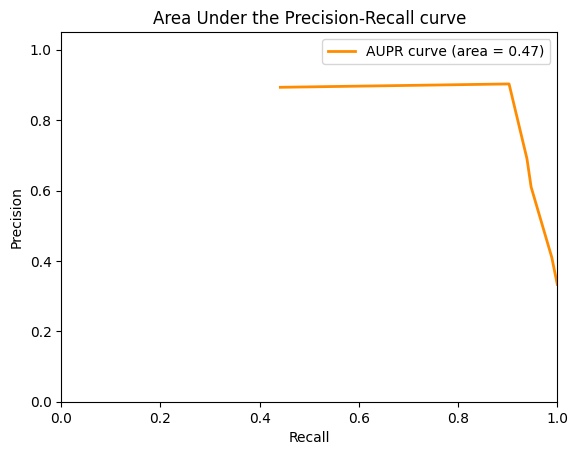

In [ ]:
from matplotlib import pyplot as plt
import math
# Testing
def test_fun(full_model,gcn_test_data,y_test):
    # X_test_new, Y_test_new = final_model(file)
    # print(X_test_new.shape, Y_test_new.shape)
    # Y_test_new = np.array(Y_test_new).astype(None)
    #k_labels = np.array(k_labels).astype(None)
    fmax, tmax = 0.0, 0.0
    precisions, recalls = [], []
    for t in range(1, 101, 1):
        test_preds = full_model.predict(x=gcn_test_data)
        #test_preds = full_model.predict(x = [seq_test_data])
        threshold = t / 100.0
        if(threshold == 1.0):
            threshold = 0.99
        print("THRESHOLD IS =====> ", threshold)
        # print(test_preds.shape)
        
        
        test_preds[test_preds>=threshold] = int(1)
        test_preds[test_preds<threshold] = int(0)
        # print(test_preds.shape)
        # print(k_labels.shape)
        rec = recall(y_test, test_preds)

        pre = precision(y_test, test_preds)
        
        recalls.append(rec)
        
        precisions.append(pre)
        # if(pre > 80):
        #   break
        f1 = f_score(y_test, test_preds)*100
        f = 2 * pre * rec / (pre + rec)
        if math.isnan(f):
          f = 0.0
        print('Recall: {0}'.format(rec*100), '     Precision: {0}'.format(pre*100),
              '     F1-score1: {0}'.format(f*100), '      F1-score2: {0}'.format(f1))

        if fmax < f:
            fmax = f
            tmax = threshold
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    sorted_index = np.argsort(recalls)
    recalls = recalls[sorted_index]
    precisions = precisions[sorted_index]
    aupr = np.trapz(precisions, recalls)
    print(f'AUPR: {aupr:0.3f}')

    plt.figure()
    plt.plot(recalls, precisions, color='darkorange', lw=2, label=f'AUPR curve (area = {aupr:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Area Under the Precision-Recall curve')
    plt.legend(loc="upper right")
    plt.savefig(f'aupr.pdf')

    return tmax
print("*****************************************GCC EVALUATION******************************************")
# gcn_test_data = tf.cast(gcn_test_data, dtype=tf.int32)
th_set_GCC = test_fun(gnn_model,gcn_test_data, y_test_onehot)
print(th_set_GCC)

# th_set_only_LSTM = test_fun(LSTM_model,test_seq_cc,test_label_cc)


# print(th_set_only_LSTM)



In [ ]:
_, test_accuracy = gnn_model.evaluate(x=gcn_test_data, y=y_test_onehot, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 93.52%


In [ ]:
gcn_test_data.shape

TensorShape([360])

In [ ]:
y_pred_logits = gnn_model.predict(gcn_test_data)

# Compute the softmax probabilities from the logits
y_pred_probs = tf.nn.softmax(y_pred_logits)

# Get the predicted labels by taking the argmax of the probabilities
y_pred = tf.argmax(y_pred_probs, axis=1)

# Convert predicted labels to one-hot encoded representation
y_pred_onehot = tf.one_hot(y_pred, depth=y_test_onehot.shape[1])

# Create a precision metric
precision_metric = tf.keras.metrics.Precision()

# Update the metric with the ground truth and predicted labels
precision_metric.update_state(y_test_onehot, y_pred_onehot)

# Compute the precision value
precision_value = precision_metric.result().numpy()

# precision_value is a scalar between 0 and 1
print("Precision:", precision_value * 100)

12/12 [==============================] - 0s 27ms/step
Precision: 90.27777910232544


In [ ]:
y_pred_logits = gnn_model.predict(gcn_test_data)

# Compute the softmax probabilities from the logits
y_pred_probs = tf.nn.softmax(y_pred_logits)

# Get the predicted labels by taking the argmax of the probabilities
y_pred = tf.argmax(y_pred_probs, axis=1)

# Convert predicted labels to one-hot encoded representation
y_pred_onehot = tf.one_hot(y_pred, depth=y_test_onehot.shape[1])

# Create a precision metric
recall_metric = tf.keras.metrics.Recall()

# Update the metric with the ground truth and predicted labels
recall_metric.update_state(y_test_onehot, y_pred_onehot)

# Compute the precision value
recall = recall_metric.result().numpy()

# precision_value is a scalar between 0 and 1
print(f"Recall: {round(recall * 100, 2)}%")

12/12 [==============================] - 1s 42ms/step
Recall: 90.28%


In [ ]:

F1SCORE =  2 * ((precision_value * recall) / (precision_value + recall + 1e-10))

In [ ]:
F1SCORE * 100

90.27777979016572